In [1]:
import glob
import cv2
import numpy as np
import pandas as pd

"""
    load data and shuffle it
"""

def bin2class(row):
    if row[0] == False and row[1] == False: return 0
    elif row[0] == False and row[1] == True: return 1
    elif row[0] == True and row[1] == False: return 2
    elif row[0] == True and row[1] == True: return 3

def load_data(rsize=None):
    if rsize is not None:
        images = [cv2.resize(cv2.imread(file),(rsize,rsize),interpolation=cv2.INTER_AREA) for file in glob.glob(r'/input/TrainingData/*.jpg')]
    else:
        images = [cv2.imread(file) for file in glob.glob(r'/input/TrainingData/*.jpg')]
    
    x = np.array(images, dtype=np.float64)          # x.shape = N, height, width, channel

    tags = pd.read_excel(r'/input/DataInfo.xlsx', true_values=["'High'", "'MIBC'"], false_values=["'Low'","'NMIBC'"])
    y = tags.iloc[:, 1:].values.astype(np.int)     # y.shape = N, grading, staging
    y = np.apply_along_axis(bin2class, 1, y)     # y.shape = (N, ) prepare for one-hot encoding of 4 classes

    # shuffle data
    N = y.shape[0]
    shuffle_mask = np.random.shuffle(np.arange(N))
    x[:] = x[shuffle_mask]
    y[:] = y[shuffle_mask]
    
    return x, y

In [2]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import LocallyConnected2D, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import LeakyReLU, Dense, Dropout, Flatten, Softmax, Activation
from keras import regularizers
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import numpy as np
# from load import load_data

x, y = load_data(128)

print(x.shape)
print(y.shape)

num_classes = 4

x_pre, y_pre = x[:30], to_categorical(y[:30], num_classes)

Using TensorFlow backend.


(478, 128, 128, 3)
(478,)


In [3]:
# , kernel_regularizer=regularizers.l2(0.001)

def LocallyConnectedNet(reg=0.0):
    model = Sequential()

    # N, 3 ,128, 128
    model.add(BatchNormalization(axis=1, input_shape=(128, 128, 3)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(LocallyConnected2D(16, 11, strides=(3, 3), kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))

    # N, 16, 40, 40
    model.add(LocallyConnected2D(16, 9, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))

    # N, 16, 32, 32
    model.add(LocallyConnected2D(16, 9, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    
    
    # 24
    model.add(LocallyConnected2D(500, 21, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    
    # 500
    model.add(Dense(500, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    #model.add(Dropout(0.5))
    
    model.add(Dense(400, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    #model.add(Dropout(0.5))
    
    model.add(Dense(300, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    #model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

Epoch 1/30
30/30 [==============================] - 9s 294ms/step - loss: 1.7072 - categorical_accuracy: 0.2000
Epoch 2/30
30/30 [==============================] - 0s 10ms/step - loss: 1.0090 - categorical_accuracy: 0.5667
Epoch 3/30
30/30 [==============================] - 0s 10ms/step - loss: 0.7876 - categorical_accuracy: 0.7333
Epoch 4/30
30/30 [==============================] - 0s 10ms/step - loss: 0.8553 - categorical_accuracy: 0.6333
Epoch 5/30
30/30 [==============================] - 0s 10ms/step - loss: 0.5414 - categorical_accuracy: 0.7667
Epoch 6/30
30/30 [==============================] - 0s 10ms/step - loss: 0.6089 - categorical_accuracy: 0.7000
Epoch 7/30
30/30 [==============================] - 0s 10ms/step - loss: 0.4831 - categorical_accuracy: 0.8000
Epoch 8/30
30/30 [==============================] - 0s 10ms/step - loss: 0.3624 - categorical_accuracy: 0.9000
Epoch 9/30
30/30 [==============================] - 0s 10ms/step - loss: 0.3467 - categorical_accuracy: 0.8667


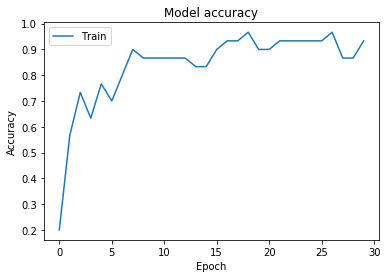

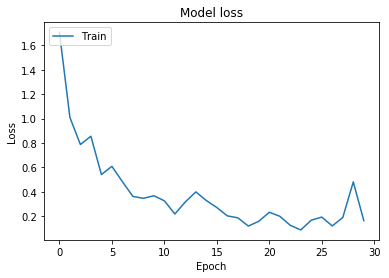

In [4]:
model = LocallyConnectedNet() # without regularization
optim = optimizers.Adam(lr=0.002)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['categorical_accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=15, epochs=30, shuffle=True)

plt.figure()
plt.plot(hist.history['categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.figure()
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Train on 400 samples, validate on 78 samples
Epoch 1/100
400/400 [==============================] - 23s 57ms/step - loss: 2.4893 - categorical_accuracy: 0.2750 - val_loss: 12.1970 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
400/400 [==============================] - 5s 11ms/step - loss: 2.7766 - categorical_accuracy: 0.3325 - val_loss: 5.4783 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
400/400 [==============================] - 5s 11ms/step - loss: 2.7194 - categorical_accuracy: 0.3025 - val_loss: 3.3531 - val_categorical_accuracy: 0.0128
Epoch 4/100
400/400 [==============================] - 5s 11ms/step - loss: 2.6466 - categorical_accuracy: 0.2900 - val_loss: 2.8543 - val_categorical_accuracy: 0.3462
Epoch 5/100
400/400 [==============================] - 5s 11ms/step - loss: 2.6014 - categorical_accuracy: 0.3325 - val_loss: 2.6647 - val_categorical_accuracy: 0.2564
Epoch 6/100
400/400 [==============================] - 5s 11ms/step - loss: 2.5198 - categorical_accuracy

400/400 [==============================] - 5s 11ms/step - loss: 0.9783 - categorical_accuracy: 0.7025 - val_loss: 5.0542 - val_categorical_accuracy: 0.2051
Epoch 98/100
400/400 [==============================] - 5s 11ms/step - loss: 0.9224 - categorical_accuracy: 0.7150 - val_loss: 3.9063 - val_categorical_accuracy: 0.2564
Epoch 99/100
400/400 [==============================] - 5s 11ms/step - loss: 0.9129 - categorical_accuracy: 0.7450 - val_loss: 3.3394 - val_categorical_accuracy: 0.3205
Epoch 100/100
400/400 [==============================] - 5s 11ms/step - loss: 1.0243 - categorical_accuracy: 0.6625 - val_loss: 3.4612 - val_categorical_accuracy: 0.1667


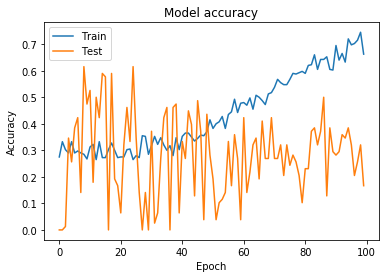

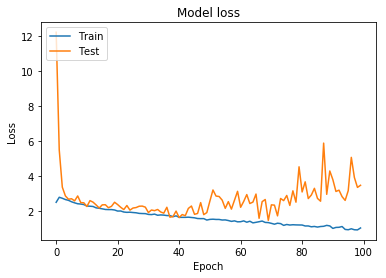

In [5]:
# split for cross validation
delim = [400,]
xs = np.split(x, delim)
ys = np.split(y, delim)

# validation
loss, acc = 0, 0
x_train, x_val = xs[0], xs[1]
y_train, y_val = to_categorical(ys[0], num_classes), to_categorical(ys[1], num_classes)

# establish model
model = LocallyConnectedNet(0.0001)

optim = optimizers.Adam(lr=0.002)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['categorical_accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=15, epochs=100, shuffle=True)

plt.figure()
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN

In [6]:
# kernel_regularizer=regularizers.l2(0.001)

def ConvNet(reg=0.0):
    model = Sequential()

    model.add(BatchNormalization(axis=1, input_shape=(128, 128, 3)))
    model.add(LeakyReLU(alpha=0.01))
    
    # 64
    model.add(Conv2D(32, 9, padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(32, 9, padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D())
    
    # 32
    model.add(Conv2D(32, 7, padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(32, 7, padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D())
    
    # 16
    model.add(Conv2D(32, 5, padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(32, 5, padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D())
    
    # 8
    model.add(Conv2D(500, 8, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    
    # N, 32*32*32
    model.add(Dense(500, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    #model.add(Dropout(0.5))

    model.add(Dense(400, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    #model.add(Dropout(0.5))

    model.add(Dense(300, kernel_regularizer=regularizers.l2(reg)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.01))
    #model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

Epoch 1/30
30/30 [==============================] - 2s 69ms/step - loss: 1.9201 - categorical_accuracy: 0.1000
Epoch 2/30
30/30 [==============================] - 0s 4ms/step - loss: 1.5156 - categorical_accuracy: 0.3333
Epoch 3/30
30/30 [==============================] - 0s 4ms/step - loss: 1.0945 - categorical_accuracy: 0.6667
Epoch 4/30
30/30 [==============================] - 0s 4ms/step - loss: 0.6965 - categorical_accuracy: 0.8667
Epoch 5/30
30/30 [==============================] - 0s 4ms/step - loss: 0.4800 - categorical_accuracy: 0.8667
Epoch 6/30
30/30 [==============================] - 0s 4ms/step - loss: 0.2969 - categorical_accuracy: 0.9333
Epoch 7/30
30/30 [==============================] - 0s 4ms/step - loss: 0.2208 - categorical_accuracy: 0.9667
Epoch 8/30
30/30 [==============================] - 0s 4ms/step - loss: 0.1641 - categorical_accuracy: 0.9667
Epoch 9/30
30/30 [==============================] - 0s 4ms/step - loss: 0.1422 - categorical_accuracy: 0.9667
Epoch 10/

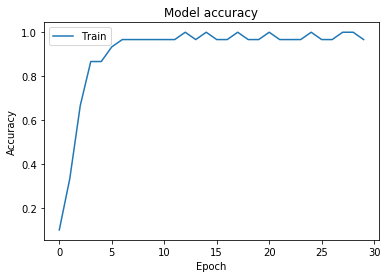

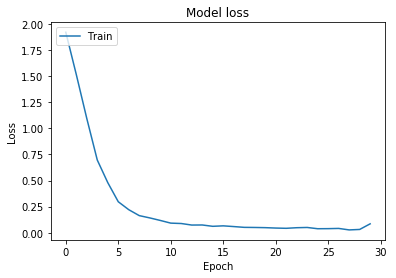

In [7]:
model = ConvNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['categorical_accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=30, epochs=30, shuffle=True)

plt.figure()
plt.plot(hist.history['categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.figure()
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Train on 400 samples, validate on 78 samples
Epoch 1/100
400/400 [==============================] - 5s 12ms/step - loss: 1.9099 - categorical_accuracy: 0.2950 - val_loss: 6.8978 - val_categorical_accuracy: 0.5000
Epoch 2/100
400/400 [==============================] - 2s 4ms/step - loss: 1.6816 - categorical_accuracy: 0.2775 - val_loss: 6.2613 - val_categorical_accuracy: 0.3077
Epoch 3/100
400/400 [==============================] - 2s 4ms/step - loss: 1.6442 - categorical_accuracy: 0.3125 - val_loss: 4.3529 - val_categorical_accuracy: 0.0128
Epoch 4/100
400/400 [==============================] - 2s 4ms/step - loss: 1.6751 - categorical_accuracy: 0.3350 - val_loss: 2.6367 - val_categorical_accuracy: 0.3333
Epoch 5/100
400/400 [==============================] - 2s 4ms/step - loss: 1.6290 - categorical_accuracy: 0.2800 - val_loss: 2.3538 - val_categorical_accuracy: 0.6026
Epoch 6/100
400/400 [==============================] - 2s 4ms/step - loss: 1.6365 - categorical_accuracy: 0.2925 - val_

Epoch 98/100
400/400 [==============================] - 2s 4ms/step - loss: 0.9831 - categorical_accuracy: 0.6975 - val_loss: 3.3522 - val_categorical_accuracy: 0.3846
Epoch 99/100
400/400 [==============================] - 2s 4ms/step - loss: 0.9349 - categorical_accuracy: 0.7050 - val_loss: 3.9189 - val_categorical_accuracy: 0.2821
Epoch 100/100
400/400 [==============================] - 2s 4ms/step - loss: 0.7868 - categorical_accuracy: 0.7925 - val_loss: 3.0920 - val_categorical_accuracy: 0.4615


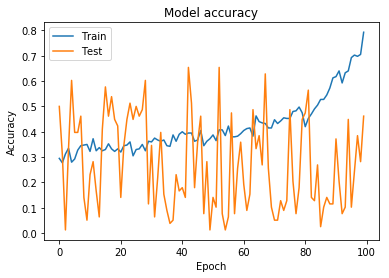

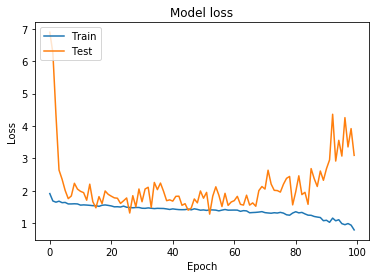

In [10]:
# split for cross validation
delim = [400,]
xs = np.split(x, delim)
ys = np.split(y, delim)

# validation
loss, acc = 0, 0
x_train, x_val = xs[0], xs[1]
#y_train, y_val = ys[0], y[1]

y_train = to_categorical(ys[0], num_classes)
y_val = to_categorical(ys[1], num_classes)

# establish model
model = ConvNet(0.0001)
    
optim = optimizers.Adam(lr=0.0015)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['categorical_accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=30, epochs=100, shuffle=True)
    
plt.figure()
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()